In [1]:
from yahoo_fin.options import *
import yfinance as yf
from yahoo_fin import stock_info as si
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime, date
from scipy.stats import norm
from math import log, sqrt, pi, exp
import pandas_datareader.data as web
import math

#Take expiration dates and use ideally the firs one in order to put it into the options chain finder
ticker_name = 'AAPl'
ticker = yf.Ticker(ticker_name)
exp = ticker.options[0]
#[0] are for calls [1] for puts
opt= ticker.option_chain(exp)

current_price = round(si.get_live_price("aapl"),0)
opt

Options(calls=         contractSymbol             lastTradeDate  strike  lastPrice    bid  \
0   AAPL220204C00105000 2022-01-28 18:38:34+00:00   105.0      63.27  64.90   
1   AAPL220204C00110000 2022-01-28 20:09:13+00:00   110.0      58.35  59.95   
2   AAPL220204C00115000 2022-01-28 15:24:00+00:00   115.0      50.75  54.95   
3   AAPL220204C00116000 2022-01-28 15:21:49+00:00   116.0      50.10  53.95   
4   AAPL220204C00119000 2022-01-27 20:27:09+00:00   119.0      39.74  50.95   
5   AAPL220204C00120000 2022-01-28 20:31:48+00:00   120.0      48.64  49.95   
6   AAPL220204C00123000 2022-01-27 16:49:15+00:00   123.0      40.10  46.95   
7   AAPL220204C00124000 2022-01-28 15:01:24+00:00   124.0      40.10  45.95   
8   AAPL220204C00125000 2022-01-26 20:44:33+00:00   125.0      34.10  44.95   
9   AAPL220204C00129000 2022-01-28 16:23:30+00:00   129.0      39.00  40.95   
10  AAPL220204C00130000 2022-01-28 19:19:31+00:00   130.0      37.26  39.95   
11  AAPL220204C00131000 2022-01-27 20:

In [2]:
#Separation into different groups
#Risk to choose from -> Low, Moderate, High risk
#For calls specific

#High Risk
#high_range = current_price*0.15 + current_price
#low_range = 0.06 * current_price + current_price

#Moderate Risk
high_range = current_price * 0.06 + current_price
low_range = current_price

#Lower Risk
#high_range = current_price
#low_range = current_price - (current_price * 0.06)

range =[]

#Dictionary of values collected 
dict = {'Strike': [],'Volume':[], 'ImpliedVolatility':[],'openinterest':[], 'inTheMoney' :[],  }

frame = pd.DataFrame(dict)
for index, row in opt[0].iterrows():
    if row['strike'] >= low_range and row['strike'] <= high_range:
        df2 = {'Strike': row['strike'], 'Volume': row['volume'], 'ImpliedVolatility': round(row['impliedVolatility'],2), 'openinterest': row['openInterest'], 'inTheMoney':row['inTheMoney']}
        frame =frame.append(df2, ignore_index = True)
        
frame


,Strike,Volume,ImpliedVolatility,openinterest,inTheMoney
0,170.0,131852.0,0.39,17791.0,1.0
1,172.5,57271.0,0.38,8157.0,0.0
2,175.0,76951.0,0.36,18269.0,0.0
3,177.5,26433.0,0.35,6558.0,0.0
4,180.0,38191.0,0.35,16098.0,0.0


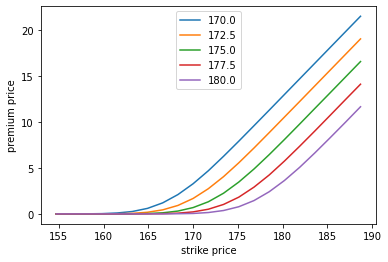

In [9]:
#x-axis -> strike price
#y-axis -> premium prices
max_price = current_price*0.1 + current_price
max = current_price * 0.1
price = current_price - max 
incrementation = current_price*0.01
strike_prices = []
premium_prices = []

while price < max_price:
    price = price+incrementation
    strike_prices.append(round(price,2))

#Equations used for the black scholes equation    
def d1(S,K,T,r,sigma):
    return(log(S/K)+(r+sigma**2/2.)*T)/(sigma*sqrt(T))
def d2(S,K,T,r,sigma):
    return d1(S,K,T,r,sigma)-sigma*sqrt(T)
#Equation used to calculate premium price of options for calls
def bs_call(S,K,T,r,sigma):
    return S*norm.cdf(d1(S,K,T,r,sigma))-K*math.exp(-r*T)*norm.cdf(d2(S,K,T,r,sigma))
#Equation used to calculate premium price of options for puts
def bs_put(S,K,T,r,sigma):
    return K*math.exp(-r*T)-S+bs_call(S,K,T,r,sigma)


#Organize date to match the format used to find amount of days left for expiration. Format -> month-day-year
expiration = exp.replace('-',' ')
expiration = expiration.split(' ')
year = expiration[0]
month = expiration[1]
day = expiration[2]
expiration[0] = month
expiration[1]= day
expiration[2] = year
expiration = expiration[0] + '-' + expiration[1] + '-' + expiration[2]

#10 year treasury price
uty = round(si.get_live_price("^tnx"),0)  


#Time to expiry
t = (datetime.strptime(expiration, "%m-%d-%Y") - datetime.utcnow()).days / 365    

#volatility
today = datetime.now()
one_year_ago = today.replace(year=today.year-1)
df1 = web.DataReader(ticker_name, 'yahoo', one_year_ago, today)
df1 = df1.sort_values(by="Date")
df1 = df1.dropna()
df1 = df1.assign(close_day_before=df1.Close.shift(1))
df1['returns'] = ((df1.Close - df1.close_day_before)/df1.close_day_before)
sigma = np.sqrt(252) * df1['returns'].std()

for y in frame.get('Strike'):
    #Strike price
    strike_price = y 
    
    #Only value that changes would be the actually stock price. This is to show what the stock price would be as it increases and shows the value of the premium price over specific prices.
    def get_premium_price(strike_prices):
        for x in strike_prices:
            #Current Price
            lcp = x
            premium= bs_call(lcp,strike_price, t, uty, sigma)
            premium_prices.append(round(premium,2))
        return premium_prices
    value = get_premium_price(strike_prices)
    #Plot strike vs. premium price
    strike = str(y)
    plt.plot(strike_prices, value, label = strike)
    premium_prices.clear()

#Graph should print out call options total premium at a given price for the current time period. Depending on what the stock price is the premium will be shown. The lower the strike price the higher
#the premium price will go up. Hence more OTM calls take longer to make more money with. 
leg = plt.legend(loc='upper center')
plt.xlabel("strike price")
plt.ylabel("premium price")
plt.show()